# How good is your medium article? -- Predicting from article titles

## Brief introduction

["How good is your medium article?"](https://www.kaggle.com/c/how-good-is-your-medium-article/overview/description) competition on Kaggle. Training set is comprised of articles published before Jul.1, 2017 and testing set consists articles published from Jul.1, 2017 till Mar. 3, 2018. Data is given in JSON format. The goal is to predict number of "claps" in the test set. This target is log1p transformed, log1p(x) = log(1+x). The evaluation metric for this competition is Mean Absolute Error.

I am predicting with 2 different approaches:
- TFIDF: using the importance of words to determine the topic of a document. In this approach, words are giving weights, so this measure is about relevance.
- Bag of Words: basically, it counts how frequent a word appears in a document and use it to .

## 1. Import and prepare data

### 1.1 Take a first look at the training data in terminal
cd /Users/Cheryl/Dropbox/Courses/Open\ ml\ ai/mlcourse.ai-master/data/kaggle_medium

head train.json > 1.json

pip install pyLDAvis

pip install gensim

I am going to explore only the "title" of the data.

In [1]:
import os
import json
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import mean_absolute_error
from scipy.sparse import csr_matrix, hstack
from sklearn.linear_model import Ridge
import gensim
from gensim.matutils  import Sparse2Corpus
from gensim.corpora import Dictionary
from gensim.models import LdaModel

/Users/Cheryl/anaconda3/lib/python3.7/site-packages/smart_open/ssh.py:34: UserWarning: paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress
  warnings.warn('paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress')


### 1.2 Clean and load data
Clean HTML tags from an article content.

In [2]:
from html.parser import HTMLParser

class MLStripper(HTMLParser):
    def __init__(self):
        self.reset()
        self.strict = False
        self.convert_charrefs= True
        self.fed = []
    def handle_data(self, d):
        self.fed.append(d)
    def get_data(self):
        return ' '.join(self.fed)

def strip_tags(html):
    s = MLStripper()
    s.feed(html)
    return s.get_data()

Read a JavaScript Object Notation (JSON) line without crashing on escape characters.

In [3]:
def read_json_line(line=None):
    result = None
    try:        
        result = json.loads(line)
    except Exception as e:      
        idx_to_replace = int(str(e).split(' ')[-1].replace(')',''))      
        new_line = list(line)
        new_line[idx_to_replace] = ' '
        new_line = ''.join(new_line)     
        return read_json_line(line=new_line)
    return result

In [4]:
PATH_TO_DATA = '/Users/Cheryl/Dropbox/Courses/Open ml ai/mlcourse.ai-master/data/kaggle_medium'

### 1.3 Preparing title data for NLP models. 

In [44]:
def extract_title(path_to_inp_json, path_to_out_txt, total_length):
    output_list = []
    with open(path_to_inp_json, encoding='utf-8') as inp_file,\
        open (path_to_out_txt, 'w', encoding='utf-8') as out_file:
        for line in tqdm_notebook(inp_file):
            json_data = read_json_line(line)
            title = json_data['title'].replace('\n', ' ').replace('\r', ' ')
            title_no_html_tags = strip_tags(title)
            output_list.append(title_no_html_tags)
    return output_list

In [45]:
%%time
train_title = extract_title(path_to_inp_json=os.path.join(PATH_TO_DATA, 'train.json'),path_to_out_txt='train_titles.txt', total_length=62313)


CPU times: user 22.7 s, sys: 1.22 s, total: 23.9 s
Wall time: 24.2 s


In [46]:
%%time
test_title = extract_title(path_to_inp_json=os.path.join(PATH_TO_DATA, 'test.json'),path_to_out_txt='test_titles.txt', total_length=34645)


CPU times: user 14.1 s, sys: 1.09 s, total: 15.2 s
Wall time: 15.9 s


Just to take a look at the raw data.

In [47]:
train_title[:5]

['Medium Terms of Service – Medium Policy – Medium',
 'Amendment to Medium Terms of Service Applicable to U.S. Government Users',
 '走入山與海之間：閩東大刀會和兩岸走私 – Yun-Chen Chien（簡韻真） – Medium',
 'How fast can a camera get? – What comes to mind – Medium',
 'A game for the lonely fox – What comes to mind – Medium']

In [48]:
test_title[:5]

['For Night Owls, the Day Starts with a Nocturnal Morning',
 'Blockchain is Memory – Words That Matter – Medium',
 'ON MORNINGS Credits – On Mornings – Medium',
 'Apple HomePod Review: Almost love – Lance Ulanoff – Medium',
 'Tips and tricks for Medium writers – 3 min read']

## 2. TFIDF
### 2.1 Extract features

In [50]:
vectorizer = TfidfVectorizer(max_features=10000)

In [51]:
X_title_train = vectorizer.fit_transform(train_title)

In [52]:
X_title_test = vectorizer.fit_transform(test_title)

In [53]:
X_title_train.shape, X_title_test.shape

((62313, 10000), (34645, 10000))

In [54]:
train_target = pd.read_csv(os.path.join(PATH_TO_DATA, 'train_log1p_recommends.csv'), 
                           index_col='id')

In [55]:
train_target.shape

(62313, 1)

In [56]:
y_train = train_target['log_recommends'].values

### 2.2 Evaluate classifier using holdout method (70% for training and 30% for validating)

In [57]:
train_partition = int(0.7 * X_title_train.shape[0])
X_title_train_part = X_title_train[:train_partition, :]
y_train_part = y_train[:train_partition]
X_title_valid =  X_title_train[train_partition:, :]
y_valid = y_train[train_partition:]

In [58]:
from sklearn.linear_model import Ridge
ridge = Ridge(random_state=2)

In [59]:
%%time
ridge.fit(X_title_train_part, y_train_part)

CPU times: user 622 ms, sys: 12.1 ms, total: 635 ms
Wall time: 632 ms


Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=2, solver='auto', tol=0.001)

In [60]:
ridge_valid = ridge.predict(X_title_valid)

Text(0.5, 1.0, 'Classifier validation on training data')

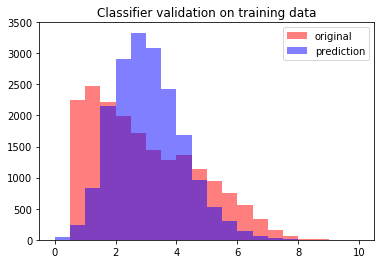

In [61]:
plt.hist(y_valid, bins=20, alpha=.5, color='red', label='original', range=(0,10))
plt.hist(ridge_valid, bins=20, alpha=.5, color='blue', label='prediction', range=(0,10))
plt.legend()
plt.title('Classifier validation on training data')

Caculate MAE for training data set, recall that our target (number of claps) is log1p transformed.

In [62]:
mae_valid = mean_absolute_error(y_valid, ridge_valid)
mae_valid, np.expm1(mae_valid)

(1.317996042021747, 2.735927229612369)

The prediction for validation is not perfect, but somewhat acceptable. On average, this model yields approximately 2.7 errors in predicting the number of claps. Next, I look at how it works for predicting the testing dataset.

### 2.3 Fit a ridge model

In [63]:
%%time
ridge.fit(X_title_train, y_train)

CPU times: user 1.03 s, sys: 14.5 ms, total: 1.05 s
Wall time: 1.04 s


Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=2, solver='auto', tol=0.001)

In [64]:
%%time
ridge_pred = ridge.predict(X_title_test)

CPU times: user 2.47 ms, sys: 1.47 ms, total: 3.94 ms
Wall time: 2.13 ms


In [66]:
def write_submission_file(prediction, filename,
    path_to_sample=os.path.join(PATH_TO_DATA, 'sample_submission.csv')):
    submission = pd.read_csv(path_to_sample, index_col='id')
    submission['log_recommends'] = prediction
    submission.to_csv(filename)

In [67]:
write_submission_file(prediction=ridge_pred, filename='title_TFIDF_ridge.csv')

**Kaggle gives this submission with MAE approximately 2.41, so this model yields about 2.41 errors in prediction.**

## 3. BoW
### 3.1 Feature extraction

In [68]:
from sklearn.feature_extraction.text import CountVectorizer

In [69]:
BoW = CountVectorizer(max_features=10000)

In [70]:
%%time
X_title_train_BoW = BoW.fit_transform(train_title)

CPU times: user 1.13 s, sys: 33.5 ms, total: 1.17 s
Wall time: 1.18 s


In [86]:
%%time
X_title_test_BoW = BoW.fit_transform(test_title)

CPU times: user 653 ms, sys: 15.9 ms, total: 669 ms
Wall time: 671 ms


### 3.2 Classifier validation

In [77]:
train_BoW_partition = int(0.7 * X_title_train_BoW.shape[0])
X_title_train_BoW_part = X_title_train_BoW[:train_BoW_partition, :]
y_train_BoW_part = y_train[:train_BoW_partition]
X_title_valid_BoW =  X_title_train_BoW[train_BoW_partition:, :]
y_valid_BoW = y_train[train_BoW_partition:]

In [78]:
ridge_BoW = Ridge(random_state=2)

In [79]:
%%time
ridge_BoW.fit(X_title_train_BoW_part, y_train_BoW_part)

CPU times: user 1.82 s, sys: 7.96 ms, total: 1.83 s
Wall time: 1.81 s


Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=2, solver='auto', tol=0.001)

In [80]:
ridge_valid_BoW = ridge_BoW.predict(X_title_valid_BoW)

Text(0.5, 1.0, 'BoW classifier validation on training data')

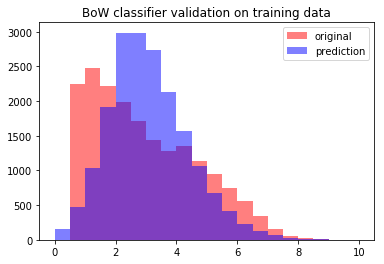

In [81]:
plt.hist(y_valid_BoW, bins=20, alpha=.5, color='red', label='original', range=(0,10))
plt.hist(ridge_valid_BoW, bins=20, alpha=.5, color='blue', label='prediction', range=(0,10))
plt.legend()
plt.title('BoW classifier validation on training data')

In [82]:
mae_valid_BoW = mean_absolute_error(y_valid_BoW, ridge_valid_BoW)
mae_valid_BoW, np.expm1(mae_valid_BoW)

(1.3759530039266137, 2.958847723171195)

### 2.3 Model fitting

In [84]:
%%time
ridge_BoW.fit(X_title_train_BoW, y_train)

CPU times: user 2.56 s, sys: 19.2 ms, total: 2.57 s
Wall time: 2.57 s


Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=2, solver='auto', tol=0.001)

In [87]:
%%time
ridge_pred_BoW = ridge_BoW.predict(X_title_test_BoW)

CPU times: user 2.82 ms, sys: 1.71 ms, total: 4.53 ms
Wall time: 2.38 ms


In [88]:
write_submission_file(prediction=ridge_pred_BoW, filename='title_BoW.csv')

**Score 2.76**